#### Analyze data With stress first

##### Step 1 Read data 

In [1]:
from pathlib import Path
import pandas as pd

# ===== config =====
DATASET_NAME = "combined_mental_condition_dataset_balanced.csv"

# Option A set this if you know the path
# data_warehouse = Path(r"/absolute/path/to/Data_Warehouse")

# Option B auto locate Data_Warehouse by walking up from current working folder
def find_data_warehouse(start: Path) -> Path:
    for p in [start] + list(start.parents):
        dw = p / "Data_Warehouse"
        if dw.exists():
            return dw
    raise FileNotFoundError("Could not locate a folder named Data_Warehouse")

try:
    data_warehouse
except NameError:
    try:
        script_dir = Path(__file__).resolve().parent  # running as a script
    except NameError:
        script_dir = Path.cwd()                       # running in a notebook
    data_warehouse = find_data_warehouse(script_dir)

# ===== load =====
data_path = data_warehouse / DATASET_NAME
df = pd.read_csv(data_path)

# ===== basic checks =====
required = {"text", "label"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(str)

print(f"Loaded {len(df)} rows from {data_path}")
print("Label distribution:")
print(df["label"].value_counts())

# df is now ready in memory


Loaded 6971 rows from d:\Sajjad-Workspace\PSS_XAI\Data_Process\Data_Warehouse\combined_mental_condition_dataset_balanced.csv
Label distribution:
label
depression    2322
stress        2274
suicide        838
none           707
anxiety        416
ptsd           414
Name: count, dtype: int64


In [2]:
# ===== word count column =====
df["word_count"] = df["text"].str.split().str.len()

# ===== class-wise statistics =====
stats = (
    df.groupby("label")["word_count"]
    .agg(["min", "max", "median"])
    .reset_index()
    .rename(columns={"min": "min_words", "max": "max_words", "median": "median_words"})
)

print("\nClass-wise word count statistics:")
print(stats.to_string(index=False))


Class-wise word count statistics:
     label  min_words  max_words  median_words
   anxiety          1        260          84.0
depression          1        400         119.0
      none          0        359          52.0
      ptsd          1        256          80.0
    stress         15        310          26.0
   suicide          1        398          86.0


In [3]:
# ==============================
# Embeddings for three models
# Dataset: expects df with columns ["text", "label"]
# Saves to in memory dicts only
# ==============================
from pathlib import Path
import numpy as np
import pandas as pd
import torch

# If df is not already loaded, uncomment and set your path
# from pathlib import Path
# data_warehouse = Path(r"/absolute/path/to/Data_Warehouse")
# df = pd.read_csv(data_warehouse / "combined_mental_condition_dataset_balanced.csv")

# ---- checks ----
required = {"text", "label"}
if "df" not in globals():
    raise NameError("df is not defined. Please load your dataset into a DataFrame named df.")
if not required.issubset(df.columns):
    raise ValueError(f"df must contain columns {required}")

texts = df["text"].astype(str).tolist()
labels = df["label"].astype(str).tolist()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# 1) HF Transformers route for BERT large with mean pooling
# ==============================
def embed_with_bert_mean_pool(texts, model_name="google-bert/bert-large-uncased", batch_size=16, max_length=256, device=DEVICE):
    from transformers import BertTokenizer, BertModel
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name).to(device)
    model.eval()

    def mean_pool(last_hidden_state, attention_mask):
        mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        masked = last_hidden_state * mask
        summed = masked.sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1e-9)
        return summed / counts

    out = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to(device)
            outputs = model(**enc)
            pooled = mean_pool(outputs.last_hidden_state, enc["attention_mask"])  # [B, H]
            out.append(pooled.cpu().numpy().astype(np.float32))
    return np.vstack(out)

# ==============================
# 2) Sentence Transformers route for MPNet and RoBERTa
# ==============================
def embed_with_sbert(texts, model_name, batch_size=64, device=DEVICE, normalize=True):
    try:
        from sentence_transformers import SentenceTransformer
    except ImportError as e:
        raise ImportError("Please install sentence-transformers: pip install -U sentence-transformers") from e
    st_model = SentenceTransformer(model_name, device=device)
    emb = st_model.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=normalize,
        show_progress_bar=True,
    ).astype(np.float32)
    return emb

# ==============================
# Run all three models
# ==============================
MODEL_BERT = "google-bert/bert-large-uncased"
MODEL_MPNET = "sentence-transformers/all-mpnet-base-v2"
MODEL_ROBERTA = "sentence-transformers/all-roberta-large-v1"

embeddings = {}         # raw or normalized embeddings per model
embeddings_norm = {}    # explicit L2 normalized copies if you want both versions
meta = {}

# BERT large uncased (mean pooled)
X_bert = embed_with_bert_mean_pool(texts, model_name=MODEL_BERT, batch_size=16, max_length=256, device=DEVICE)
embeddings["bert_large_uncased"] = X_bert
# make a normalized copy for cosine based work
norms = np.linalg.norm(X_bert, axis=1, keepdims=True).clip(min=1e-9)
embeddings_norm["bert_large_uncased"] = (X_bert / norms).astype(np.float32)
meta["bert_large_uncased"] = {"model_name": MODEL_BERT, "dims": X_bert.shape[1], "backend": "hf_mean_pool"}

# all mpnet base v2 (Sentence Transformers, already normalized by default)
X_mpnet = embed_with_sbert(texts, model_name=MODEL_MPNET, batch_size=64, device=DEVICE, normalize=True)
embeddings["all_mpnet_base_v2"] = X_mpnet
embeddings_norm["all_mpnet_base_v2"] = X_mpnet.copy()
meta["all_mpnet_base_v2"] = {"model_name": MODEL_MPNET, "dims": X_mpnet.shape[1], "backend": "sentence_transformers"}

# all roberta large v1 (Sentence Transformers, already normalized by default)
X_roberta = embed_with_sbert(texts, model_name=MODEL_ROBERTA, batch_size=32, device=DEVICE, normalize=True)
embeddings["all_roberta_large_v1"] = X_roberta
embeddings_norm["all_roberta_large_v1"] = X_roberta.copy()
meta["all_roberta_large_v1"] = {"model_name": MODEL_ROBERTA, "dims": X_roberta.shape[1], "backend": "sentence_transformers"}

# ==============================
# Quick sanity checks in memory
# ==============================
print("Shapes:")
for k, v in embeddings.items():
    print(f"  {k}: {v.shape}")

# Verify row alignment with df
n = len(df)
assert all(v.shape[0] == n for v in embeddings.values()), "Row count mismatch between df and some embeddings"

# Optional mini cosine self similarity check
def cosine_self_check(X, n_samples=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = rng.choice(X.shape[0], size=min(n_samples, X.shape[0]), replace=False)
    sub = X[idx]
    # normalize if not already
    nn = np.linalg.norm(sub, axis=1, keepdims=True).clip(min=1e-9)
    subn = sub / nn
    sim = subn @ subn.T
    return idx, np.round(sim, 3)

for name, X in embeddings.items():
    idx, sim = cosine_self_check(X)
    print(f"\n{name} sample cosine self similarity on rows {idx.tolist()}:\n{sim}")

# At this point you have:
#   embeddings          dict of numpy arrays per model
#   embeddings_norm     dict of L2 normalized arrays per model
#   meta                dict with model info
# and the original df for labels and text


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

Batches:   0%|          | 0/218 [00:00<?, ?it/s]

Shapes:
  bert_large_uncased: (6971, 1024)
  all_mpnet_base_v2: (6971, 768)
  all_roberta_large_v1: (6971, 1024)

bert_large_uncased sample cosine self similarity on rows [5392, 3058, 4561, 621, 3018]:
[[1.    0.873 0.83  0.879 0.869]
 [0.873 1.    0.821 0.897 0.87 ]
 [0.83  0.821 1.    0.853 0.781]
 [0.879 0.897 0.853 1.    0.852]
 [0.869 0.87  0.781 0.852 1.   ]]

all_mpnet_base_v2 sample cosine self similarity on rows [5392, 3058, 4561, 621, 3018]:
[[ 1.    -0.     0.043 -0.016 -0.069]
 [-0.     1.     0.006  0.17   0.056]
 [ 0.043  0.006  1.     0.226  0.055]
 [-0.016  0.17   0.226  1.     0.228]
 [-0.069  0.056  0.055  0.228  1.   ]]

all_roberta_large_v1 sample cosine self similarity on rows [5392, 3058, 4561, 621, 3018]:
[[ 1.     0.051 -0.022  0.069  0.062]
 [ 0.051  1.    -0.008  0.144  0.125]
 [-0.022 -0.008  1.     0.233 -0.   ]
 [ 0.069  0.144  0.233  1.     0.19 ]
 [ 0.062  0.125 -0.     0.19   1.   ]]


In [3]:
# =========================================
# Step 3: Clustering and similarity analysis
# Requirements:
#   - df with columns ["text", "label"]
#   - embeddings dict with keys:
#       "bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"
#     and values are numpy arrays of shape [n_samples, n_dims]
# Outputs (in memory only):
#   results[model_key] = {
#       "cluster_ids": np.ndarray,
#       "metrics": {"ARI": float, "NMI": float, "silhouette": float or None},
#       "crosstab": pd.DataFrame,
#       "centroid_similarity": pd.DataFrame
#   }
# =========================================

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# ---- checks ----
if "df" not in globals():
    raise NameError("df is not defined. Please load your dataset into a DataFrame named df.")
if "embeddings" not in globals():
    raise NameError("embeddings dict is not defined. Please generate embeddings first.")

required_models = ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]
for m in required_models:
    if m not in embeddings:
        raise KeyError(f"Missing embeddings for {m}. Make sure you ran Step 2 for all three models.")

labels = df["label"].astype(str).tolist()
label_series = pd.Series(labels, dtype=str)
label_set = sorted(label_series.unique().tolist())
n_classes = len(label_set)
n_samples = len(label_series)

def run_clustering_and_similarity(X: np.ndarray, labels_series: pd.Series, label_set: list[str]) -> dict:
    # KMeans clustering
    if X.shape[0] != len(labels_series):
        raise ValueError("Row count mismatch between embeddings and labels.")
    if n_classes < 2:
        raise ValueError("Need at least two unique labels for clustering.")

    kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=20)
    cluster_ids = kmeans.fit_predict(X)

    # Metrics
    ari = adjusted_rand_score(labels_series, cluster_ids)
    nmi = normalized_mutual_info_score(labels_series, cluster_ids)

    # Silhouette requires at least 2 clusters and less than number of samples
    sil = None
    if len(np.unique(cluster_ids)) >= 2 and X.shape[0] > len(np.unique(cluster_ids)):
        sil = silhouette_score(X, cluster_ids)

    # Cross tab
    ct = pd.crosstab(pd.Series(labels_series, name="true_label"),
                     pd.Series(cluster_ids, name="cluster"))

    # Centroid cosine similarity between labels
    idx_map = {lab: np.where(labels_series.values == lab)[0] for lab in label_set}
    centroids = np.vstack([X[idxs].mean(axis=0) for lab, idxs in idx_map.items()])
    sim_mat = cosine_similarity(centroids)
    sim_df = pd.DataFrame(sim_mat, index=label_set, columns=label_set)

    return {
        "cluster_ids": cluster_ids,
        "metrics": {"ARI": float(ari), "NMI": float(nmi), "silhouette": None if sil is None else float(sil)},
        "crosstab": ct,
        "centroid_similarity": sim_df,
    }

# Run for all three models
results = {}
for key in required_models:
    print(f"\n=== Analyzing model: {key} ===")
    X = embeddings[key]
    res = run_clustering_and_similarity(X, label_series, label_set)
    results[key] = res

    # Quick summary
    m = res["metrics"]
    print(f"ARI: {m['ARI']:.3f}  NMI: {m['NMI']:.3f}  Silhouette: {m['silhouette'] if m['silhouette'] is not None else 'NA'}")
    print("Cross tab head:")
    display(res["crosstab"])  # in notebooks this will render a table

# After this:
#   - results["bert_large_uncased"]["metrics"] gives the metric dict
#   - results["all_mpnet_base_v2"]["centroid_similarity"] is the label by label cosine matrix
#   - results["all_roberta_large_v1"]["crosstab"] is the cross tab DataFrame



=== Analyzing model: bert_large_uncased ===
ARI: 0.109  NMI: 0.176  Silhouette: 0.004328218288719654
Cross tab head:


cluster,0,1,2,3,4,5
true_label,,,,,,
anxiety,14,10,15,127,94,156
depression,88,69,151,749,873,392
none,6,597,10,34,11,49
ptsd,8,7,13,106,107,173
stress,674,60,192,478,304,566
suicide,44,50,85,242,334,83



=== Analyzing model: all_mpnet_base_v2 ===
ARI: 0.251  NMI: 0.336  Silhouette: 0.024554423987865448
Cross tab head:


cluster,0,1,2,3,4,5
true_label,,,,,,
anxiety,36,246,29,8,34,63
depression,772,374,918,37,129,92
none,5,6,0,692,0,4
ptsd,53,185,27,9,126,14
stress,229,84,72,119,843,927
suicide,216,20,478,41,40,43



=== Analyzing model: all_roberta_large_v1 ===
ARI: 0.255  NMI: 0.347  Silhouette: 0.032692547887563705
Cross tab head:


cluster,0,1,2,3,4,5
true_label,,,,,,
anxiety,17,9,30,36,50,274
depression,68,36,1185,202,174,657
none,694,0,0,2,1,10
ptsd,7,4,31,13,159,200
stress,98,375,47,896,752,106
suicide,50,14,590,85,48,51


🔎 How to read these:

ARI/NMI compare discovered clusters to your actual labels. Values closer to 1 are better.

Silhouette measures cluster tightness vs separation (range −1 to 1). Positive but very close to zero here → embeddings overlap a lot in raw space.

So far, all-mpnet-base-v2 and all-roberta-large-v1 are clearly outperforming BERT large uncased on your task, with RoBERTa slightly ahead.

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# checks
if "df" not in globals():
    raise NameError("df is not defined")
if "embeddings" not in globals():
    raise NameError("embeddings is not defined")

labels_series = df["label"].astype(str)
label_list = sorted(labels_series.unique().tolist())
idx_map = {lab: np.where(labels_series.values == lab)[0] for lab in label_list}

def centroid_cosine_similarity(X: np.ndarray, idx_map: dict, label_list: list) -> pd.DataFrame:
    centroids = np.vstack([X[idxs].mean(axis=0) for lab, idxs in idx_map.items()])
    sim = cosine_similarity(centroids)
    return pd.DataFrame(sim, index=label_list, columns=label_list)

# compute per model matrices
sim_matrices = {}
for model_key in ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]:
    if model_key not in embeddings:
        raise KeyError(f"Missing embeddings for {model_key}")
    X = embeddings[model_key]
    if X.shape[0] != len(labels_series):
        raise ValueError(f"Row count mismatch for {model_key}")
    sim_matrices[model_key] = centroid_cosine_similarity(X, idx_map, label_list)

# long format table for easy analysis
records = []
for model_key, sim_df in sim_matrices.items():
    for a in label_list:
        for b in label_list:
            if a == b:
                continue
            records.append({
                "model": model_key,
                "label": a,
                "other_label": b,
                "cosine_similarity": float(sim_df.loc[a, b]),
            })
all_pairwise = pd.DataFrame(records)

# optional convenience reports
def report_for_label(model_key: str, anchor: str, top_k: int | None = None) -> pd.DataFrame:
    sim_df = sim_matrices[model_key]
    s = sim_df.loc[anchor].drop(anchor).sort_values(ascending=False)
    out = s.reset_index().rename(columns={"index": "other_label", anchor: "cosine_similarity"})
    return out.head(top_k) if top_k else out

# examples
print("\nCentroid cosine similarity matrices by model:")
for k, m in sim_matrices.items():
    print(f"\n=== {k} ===")
    display(m.round(3))

print("\nPairwise table head:")
display(all_pairwise.head())

# example focused reports
for k in ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]:
    print(f"\n{k}  Stress vs others")
    display(report_for_label(k, "stress").round(3))
    print(f"\n{k}  Depression vs others")
    display(report_for_label(k, "depression").round(3))



Centroid cosine similarity matrices by model:

=== bert_large_uncased ===


,anxiety,depression,none,ptsd,stress,suicide
anxiety,1.000,0.995,0.971,0.997,0.992,0.992
depression,0.995,1.000,0.969,0.994,0.991,0.998
none,0.971,0.969,1.000,0.969,0.964,0.965
ptsd,0.997,0.994,0.969,1.000,0.992,0.992
stress,0.992,0.991,0.964,0.992,1.000,0.990
suicide,0.992,0.998,0.965,0.992,0.990,1.000



=== all_mpnet_base_v2 ===


,anxiety,depression,none,ptsd,stress,suicide
anxiety,1.000,0.796,0.056,0.845,0.725,0.696
depression,0.796,1.000,0.057,0.781,0.740,0.931
none,0.056,0.057,1.000,0.050,0.025,0.030
ptsd,0.845,0.781,0.050,1.000,0.759,0.730
stress,0.725,0.740,0.025,0.759,1.000,0.703
suicide,0.696,0.931,0.030,0.730,0.703,1.000



=== all_roberta_large_v1 ===


,anxiety,depression,none,ptsd,stress,suicide
anxiety,1.000,0.775,0.122,0.843,0.680,0.666
depression,0.775,1.000,0.163,0.730,0.714,0.929
none,0.122,0.163,1.000,0.058,0.030,0.114
ptsd,0.843,0.730,0.058,1.000,0.748,0.678
stress,0.680,0.714,0.030,0.748,1.000,0.698
suicide,0.666,0.929,0.114,0.678,0.698,1.000



Pairwise table head:


,model,label,other_label,cosine_similarity
0,bert_large_uncased,anxiety,depression,0.995466
1,bert_large_uncased,anxiety,none,0.970794
2,bert_large_uncased,anxiety,ptsd,0.997091
3,bert_large_uncased,anxiety,stress,0.992027
4,bert_large_uncased,anxiety,suicide,0.991502



bert_large_uncased  Stress vs others


,other_label,cosine_similarity
0,ptsd,0.992
1,anxiety,0.992
2,depression,0.991
3,suicide,0.990
4,none,0.964



bert_large_uncased  Depression vs others


,other_label,cosine_similarity
0,suicide,0.998
1,anxiety,0.995
2,ptsd,0.994
3,stress,0.991
4,none,0.969



all_mpnet_base_v2  Stress vs others


,other_label,cosine_similarity
0,ptsd,0.759
1,depression,0.740
2,anxiety,0.725
3,suicide,0.703
4,none,0.025



all_mpnet_base_v2  Depression vs others


,other_label,cosine_similarity
0,suicide,0.931
1,anxiety,0.796
2,ptsd,0.781
3,stress,0.740
4,none,0.057



all_roberta_large_v1  Stress vs others


,other_label,cosine_similarity
0,ptsd,0.748
1,depression,0.714
2,suicide,0.698
3,anxiety,0.680
4,none,0.030



all_roberta_large_v1  Depression vs others


,other_label,cosine_similarity
0,suicide,0.929
1,anxiety,0.775
2,ptsd,0.730
3,stress,0.714
4,none,0.163


In [8]:
# =========================================
# Step 5  Extrinsic evaluation with classification
# Uses embeddings as features for Logistic Regression
# No files are written; everything stays in memory
# Requirements in memory:
#   - df with columns ["text", "label"]
#   - embeddings dict with keys:
#       "bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"
# =========================================
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

# checks
if "df" not in globals():
    raise NameError("df is not defined")
if "embeddings" not in globals():
    raise NameError("embeddings dict is not defined")

required_models = ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]
for m in required_models:
    if m not in embeddings:
        raise KeyError(f"Missing embeddings for {m}. Run Step 2 first.")

# labels
labels = df["label"].astype(str).tolist()
le = LabelEncoder()
y = le.fit_transform(labels)
class_names = list(le.classes_)
n_classes = len(class_names)

# common split indices for fair comparison
idx_all = np.arange(len(y))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    idx_all, y, test_size=0.2, random_state=42, stratify=y
)

# classifier configuration
clf_base = LogisticRegression(
    max_iter=5000,
    solver="saga",
    n_jobs=-1,
    multi_class="auto"
)

def evaluate_model(X: np.ndarray, name: str):
    if X.shape[0] != len(y):
        raise ValueError(f"Row count mismatch for {name}")
    # split
    X_train = X[X_train_idx]
    X_test = X[X_test_idx]

    # train
    clf = clf_base
    clf.fit(X_train, y_train)

    # predict
    y_pred = clf.predict(X_test)

    # base metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    # per class report and confusion matrix (in memory)
    report_df = pd.DataFrame(
        classification_report(
            y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0
        )
    ).transpose()
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, y_pred), index=class_names, columns=class_names
    )

    # ROC AUC one vs rest if probabilities available
    try:
        y_prob = clf.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
        if n_classes == 2:
            roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        else:
            roc_auc = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = np.nan

    # cross validation for robustness
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_validate(
        clf_base, X, y,
        cv=skf,
        scoring={"acc": "accuracy", "f1_macro": "f1_macro", "f1_weighted": "f1_weighted"},
        n_jobs=-1,
        return_train_score=False
    )

    cv_summary = {
        "cv_acc_mean": float(np.mean(cv_scores["test_acc"])),
        "cv_acc_std": float(np.std(cv_scores["test_acc"])),
        "cv_f1_macro_mean": float(np.mean(cv_scores["test_f1_macro"])),
        "cv_f1_macro_std": float(np.std(cv_scores["test_f1_macro"])),
        "cv_f1_weighted_mean": float(np.mean(cv_scores["test_f1_weighted"])),
        "cv_f1_weighted_std": float(np.std(cv_scores["test_f1_weighted"])),
    }

    holdout_summary = {
        "model": name,
        "accuracy": float(acc),
        "f1_macro": float(f1_macro),
        "f1_weighted": float(f1_weighted),
        "roc_auc_ovr": float(roc_auc) if roc_auc == roc_auc else np.nan,
    }

    artifacts = {
        "report_df": report_df,
        "confusion_matrix_df": cm_df,
        "y_test": y_test,
        "y_pred": y_pred,
    }

    return holdout_summary, cv_summary, artifacts

# run evaluations
holdout_rows = []
cv_rows = []
artifacts_by_model = {}

for model_key in required_models:
    print(f"\n=== Classifying with embeddings from: {model_key} ===")
    X = embeddings[model_key]
    holdout, cv_summary, arts = evaluate_model(X, model_key)
    holdout_rows.append(holdout)
    cv_rows.append({"model": model_key, **cv_summary})
    artifacts_by_model[model_key] = arts

# summaries in memory
holdout_df = pd.DataFrame(holdout_rows).sort_values(by="f1_macro", ascending=False).reset_index(drop=True)
cv_df = pd.DataFrame(cv_rows).sort_values(by="cv_f1_macro_mean", ascending=False).reset_index(drop=True)

print("\n=== Holdout results ===")
print(holdout_df)

print("\n=== Cross validation results ===")
print(cv_df)

# Example access:
# artifacts_by_model["all_roberta_large_v1"]["confusion_matrix_df"]
# artifacts_by_model["all_mpnet_base_v2"]["report_df"]



=== Classifying with embeddings from: bert_large_uncased ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Classifying with embeddings from: all_mpnet_base_v2 ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Classifying with embeddings from: all_roberta_large_v1 ===


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Holdout results ===
                  model  accuracy  f1_macro  f1_weighted  roc_auc_ovr
0  all_roberta_large_v1  0.791398  0.725044     0.781735     0.950554
1     all_mpnet_base_v2  0.773477  0.706839     0.764820     0.945893
2    bert_large_uncased  0.766308  0.700072     0.760689     0.936652

=== Cross validation results ===
                  model  cv_acc_mean  cv_acc_std  cv_f1_macro_mean  \
0  all_roberta_large_v1     0.786689    0.011349          0.717819   
1     all_mpnet_base_v2     0.773634    0.013088          0.703927   
2    bert_large_uncased     0.750970    0.010161          0.670995   

   cv_f1_macro_std  cv_f1_weighted_mean  cv_f1_weighted_std  
0         0.018242             0.776887            0.012182  
1         0.018658             0.763082            0.012915  
2         0.016809             0.742815            0.008802  


Classification confirms the ranking

all roberta large v1 is best

all mpnet base v2 is close behind

bert large uncased trails both

In [9]:
# 1) Per class reports and confusion matrices already in artifacts_by_model
#    This prints a quick view for each model
for k in ["all_roberta_large_v1", "all_mpnet_base_v2", "bert_large_uncased"]:
    print(f"\n=== Per class report for {k} ===")
    display(artifacts_by_model[k]["report_df"].round(3))
    print(f"\n=== Confusion matrix for {k} ===")
    display(artifacts_by_model[k]["confusion_matrix_df"])



=== Per class report for all_roberta_large_v1 ===


,precision,recall,f1-score,support
anxiety,0.745,0.494,0.594,83.000
depression,0.732,0.858,0.790,465.000
none,0.945,0.972,0.958,141.000
ptsd,0.717,0.518,0.601,83.000
stress,0.860,0.901,0.880,455.000
suicide,0.655,0.440,0.527,168.000
accuracy,0.791,0.791,0.791,0.791
macro avg,0.776,0.697,0.725,1395.000
weighted avg,0.786,0.791,0.782,1395.000



=== Confusion matrix for all_roberta_large_v1 ===


,anxiety,depression,none,ptsd,stress,suicide
anxiety,41,27,0,1,14,0
depression,6,399,1,4,24,31
none,0,3,137,0,1,0
ptsd,5,11,0,43,19,5
stress,2,26,6,8,410,3
suicide,1,79,1,4,9,74



=== Per class report for all_mpnet_base_v2 ===


,precision,recall,f1-score,support
anxiety,0.702,0.482,0.571,83.000
depression,0.719,0.837,0.773,465.000
none,0.964,0.957,0.961,141.000
ptsd,0.631,0.494,0.554,83.000
stress,0.839,0.879,0.858,455.000
suicide,0.643,0.440,0.523,168.000
accuracy,0.773,0.773,0.773,0.773
macro avg,0.750,0.682,0.707,1395.000
weighted avg,0.767,0.773,0.765,1395.000



=== Confusion matrix for all_mpnet_base_v2 ===


,anxiety,depression,none,ptsd,stress,suicide
anxiety,40,23,0,4,15,1
depression,8,389,0,6,29,33
none,0,5,135,0,1,0
ptsd,4,10,0,41,24,4
stress,4,33,4,11,400,3
suicide,1,81,1,3,8,74



=== Per class report for bert_large_uncased ===


,precision,recall,f1-score,support
anxiety,0.600,0.470,0.527,83.000
depression,0.701,0.839,0.764,465.000
none,0.955,0.908,0.931,141.000
ptsd,0.627,0.566,0.595,83.000
stress,0.877,0.859,0.868,455.000
suicide,0.622,0.440,0.516,168.000
accuracy,0.766,0.766,0.766,0.766
macro avg,0.730,0.680,0.700,1395.000
weighted avg,0.764,0.766,0.761,1395.000



=== Confusion matrix for bert_large_uncased ===


,anxiety,depression,none,ptsd,stress,suicide
anxiety,39,25,0,4,13,2
depression,12,390,1,6,25,31
none,3,6,128,0,2,2
ptsd,9,13,0,47,11,3
stress,2,35,3,17,391,7
suicide,0,87,2,1,4,74


In [10]:
# 2) Out of fold true label probability as a suspicion score
#    Higher suspicion means lower confidence in the given label
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

labels = df["label"].astype(str).tolist()
y = le.transform(labels)
class_names = list(le.classes_)
n_classes = len(class_names)

def oof_true_label_prob(X, y, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof_proba = np.zeros((len(y), n_classes), dtype=float)
    for tr, va in skf.split(X, y):
        clf = LogisticRegression(
            max_iter=5000, solver="saga", n_jobs=-1, multi_class="auto"
        )
        clf.fit(X[tr], y[tr])
        oof_proba[va] = clf.predict_proba(X[va])
    p_true = oof_proba[np.arange(len(y)), y]
    y_oof_pred = oof_proba.argmax(axis=1)
    return p_true, y_oof_pred, oof_proba

oof_results = {}
for key in ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]:
    X = embeddings[key]
    p_true, y_pred_oof, proba = oof_true_label_prob(X, y, n_splits=5)
    oof_results[key] = {"p_true": p_true, "y_pred_oof": y_pred_oof, "proba": proba}

# build a single DataFrame with suspicion scores
out = pd.DataFrame({
    "text": df["text"].astype(str).values,
    "true_label": labels
})

for key in ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]:
    out[f"p_true_{key}"] = oof_results[key]["p_true"]

# mean and min across models
out["p_true_mean"] = out[[c for c in out.columns if c.startswith("p_true_")]].mean(axis=1)
out["p_true_min"] = out[[c for c in out.columns if c.startswith("p_true_")]].min(axis=1)

# suspicion scores
out["suspicion_mean"] = 1.0 - out["p_true_mean"]
out["suspicion_max"] = 1.0 - out["p_true_min"]

# top candidates for label issues
top_k = 30
suspects = out.sort_values("suspicion_mean", ascending=False).head(top_k)
print("\nTop suspected label issues by mean suspicion:")
display(suspects[["true_label", "suspicion_mean", "suspicion_max", "p_true_mean"] + [c for c in out.columns if c.startswith("p_true_")]].reset_index(drop=True))


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nipua\AppData\Local\anaconda3\envs\py312


Top suspected label issues by mean suspicion:


,true_label,suspicion_mean,suspicion_max,p_true_mean,p_true_bert_large_uncased,p_true_all_mpnet_base_v2,p_true_all_roberta_large_v1,p_true_mean,p_true_min
0,ptsd,0.996686,1.000000,0.003314,3.106641e-07,0.006507,0.003435,0.003314,3.106641e-07
1,anxiety,0.995303,0.999175,0.004697,8.253795e-04,0.006890,0.006377,0.004697,8.253795e-04
2,anxiety,0.995171,0.997745,0.004829,9.475134e-03,0.002758,0.002255,0.004829,2.254873e-03
3,anxiety,0.994033,0.999471,0.005967,5.293023e-04,0.010754,0.006618,0.005967,5.293023e-04
4,ptsd,0.993836,0.995564,0.006164,4.435913e-03,0.006515,0.007540,0.006164,4.435913e-03
5,anxiety,0.992797,0.993955,0.007203,7.468359e-03,0.008097,0.006045,0.007203,6.044794e-03
6,suicide,0.992742,0.995444,0.007258,4.555884e-03,0.011359,0.005859,0.007258,4.555884e-03
7,anxiety,0.992508,0.996830,0.007492,3.169640e-03,0.008775,0.010531,0.007492,3.169640e-03
8,ptsd,0.992192,0.999961,0.007808,3.904520e-05,0.014576,0.008810,0.007808,3.904520e-05
9,ptsd,0.991443,0.994474,0.008557,9.843354e-03,0.005526,0.010302,0.008557,5.525630e-03


In [11]:
# 3) Cross model disagreement flags
#    Count how often models disagree with the given label on out of fold predictions
pred_cols = []
for key in ["bert_large_uncased", "all_mpnet_base_v2", "all_roberta_large_v1"]:
    pred = oof_results[key]["y_pred_oof"]
    out[f"pred_oof_{key}"] = [class_names[i] for i in pred]
    pred_cols.append(f"pred_oof_{key}")

# number of models that predict the true label
out["num_models_match_true"] = (out[pred_cols].values == np.array(out["true_label"])[:, None]).sum(axis=1)

# majority vote prediction
def majority_vote(row):
    votes = row[pred_cols].tolist()
    return pd.Series(votes).mode().iloc[0]

out["majority_vote"] = out.apply(majority_vote, axis=1)

# disagreement score and final suspect list combining probability and disagreement
out["disagree_count"] = (len(pred_cols) - out["num_models_match_true"]).astype(int)
ranked_suspects = out.sort_values(
    ["disagree_count", "suspicion_mean"], ascending=[False, False]
).head(top_k)

print("\nTop suspected label issues by disagreement then probability:")
display(ranked_suspects[[
    "true_label", "majority_vote", "disagree_count", "suspicion_mean", "p_true_mean"
] + pred_cols].reset_index(drop=True))



Top suspected label issues by disagreement then probability:


,true_label,majority_vote,disagree_count,suspicion_mean,p_true_mean,pred_oof_bert_large_uncased,pred_oof_all_mpnet_base_v2,pred_oof_all_roberta_large_v1
0,ptsd,anxiety,3,0.996686,0.003314,anxiety,suicide,depression
1,anxiety,depression,3,0.995303,0.004697,ptsd,suicide,depression
2,anxiety,stress,3,0.995171,0.004829,stress,stress,stress
3,anxiety,depression,3,0.994033,0.005967,suicide,depression,depression
4,ptsd,stress,3,0.993836,0.006164,stress,stress,stress
5,anxiety,stress,3,0.992797,0.007203,stress,stress,stress
6,suicide,stress,3,0.992742,0.007258,stress,stress,stress
7,anxiety,stress,3,0.992508,0.007492,suicide,stress,stress
8,ptsd,depression,3,0.992192,0.007808,depression,depression,depression
9,ptsd,depression,3,0.991443,0.008557,depression,depression,depression


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


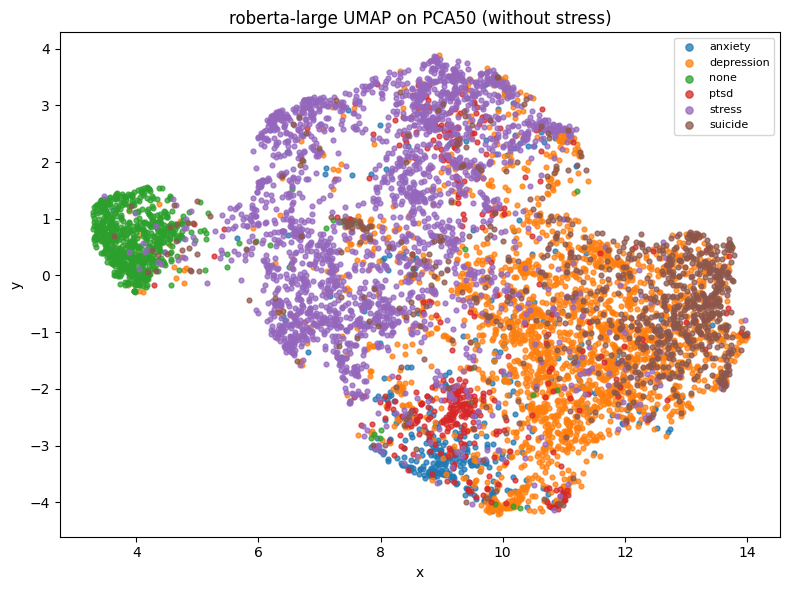

In [ ]:
# =========================================
# Step 4  Dimensionality reduction and visualization
# Model  all_roberta_large_v1
# Inputs expected in memory:
#   - df with columns ["text", "label"]
#   - embeddings["all_roberta_large_v1"]  numpy array [n_samples, dim]
# Output:
#   - coords_2d  numpy array [n_samples, 2]
#   - coords_df  pandas DataFrame with x y label
#   - a single matplotlib scatter plot shown inline
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# checks
if "df" not in globals():
    raise NameError("df is not defined")
if "embeddings" not in globals() or "all_roberta_large_v1" not in embeddings:
    raise KeyError("Missing embeddings for all_roberta_large_v1")

X = embeddings["all_roberta_large_v1"]
labels = df["label"].astype(str).tolist()
if X.shape[0] != len(labels):
    raise ValueError("Row count mismatch between embeddings and labels")

# reduce to 50 with PCA for stability
pca_50 = PCA(n_components=50, random_state=42)
X_50 = pca_50.fit_transform(X)

# try UMAP first then fall back to tSNE
use_umap = True
coords_2d = None
method_tag = "UMAP"
try:
    import umap
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    coords_2d = reducer.fit_transform(X_50)
except Exception:
    from sklearn.manifold import TSNE
    method_tag = "tSNE"
    reducer = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=42)
    coords_2d = reducer.fit_transform(X_50)

coords_df = pd.DataFrame({"x": coords_2d[:, 0], "y": coords_2d[:, 1], "label": labels})

# single plot, default matplotlib colors, no file save
plt.figure(figsize=(8, 6))
label_display_map = {"suicide": "suicidal"}
for lab in sorted(coords_df["label"].unique()):
    sub = coords_df[coords_df["label"] == lab]
    plt.scatter(sub["x"], sub["y"], s=12, alpha=0.75, label=lab)

plt.title(f"roberta-large {method_tag} on PCA50 (with stress)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
plt.show()

# coords_2d and coords_df remain in memory for further analysis


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


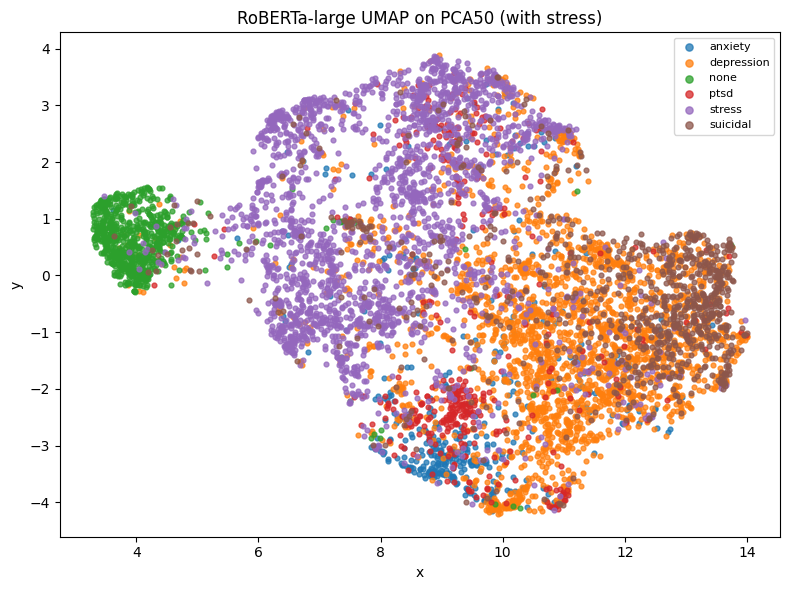

In [11]:
# =========================================
# Step 4  Dimensionality reduction and visualization
# Model  all_roberta_large_v1
# Inputs expected in memory:
#   - df with columns ["text", "label"]
#   - embeddings["all_roberta_large_v1"]  numpy array [n_samples, dim]
# Output:
#   - coords_2d  numpy array [n_samples, 2]
#   - coords_df  pandas DataFrame with x y label
#   - a single matplotlib scatter plot shown inline
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# checks
if "df" not in globals():
    raise NameError("df is not defined")
if "embeddings" not in globals() or "all_roberta_large_v1" not in embeddings:
    raise KeyError("Missing embeddings for all_roberta_large_v1")

X = embeddings["all_roberta_large_v1"]
labels = df["label"].astype(str).tolist()
if X.shape[0] != len(labels):
    raise ValueError("Row count mismatch between embeddings and labels")

# reduce to 50 with PCA for stability
pca_50 = PCA(n_components=50, random_state=42)
X_50 = pca_50.fit_transform(X)

# try UMAP first then fall back to tSNE
coords_2d = None
method_tag = "UMAP"
try:
    import umap
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    coords_2d = reducer.fit_transform(X_50)
except Exception:
    from sklearn.manifold import TSNE
    method_tag = "tSNE"
    reducer = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=42)
    coords_2d = reducer.fit_transform(X_50)

coords_df = pd.DataFrame({"x": coords_2d[:, 0], "y": coords_2d[:, 1], "label": labels})

# single plot, default matplotlib colors, no file save
plt.figure(figsize=(8, 6))

# display only mapping
label_display_map = {"suicide": "suicidal"}

for lab in sorted(coords_df["label"].unique()):
    sub = coords_df[coords_df["label"] == lab]
    display_lab = label_display_map.get(lab, lab)  # legend label only
    plt.scatter(sub["x"], sub["y"], s=12, alpha=0.75, label=display_lab)

plt.title(f"RoBERTa-large {method_tag} on PCA50 (with stress)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
plt.show()

# coords_2d and coords_df remain in memory for further analysis


#### Without Stress

Reused embeddings by subsetting the full dataset mask.


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


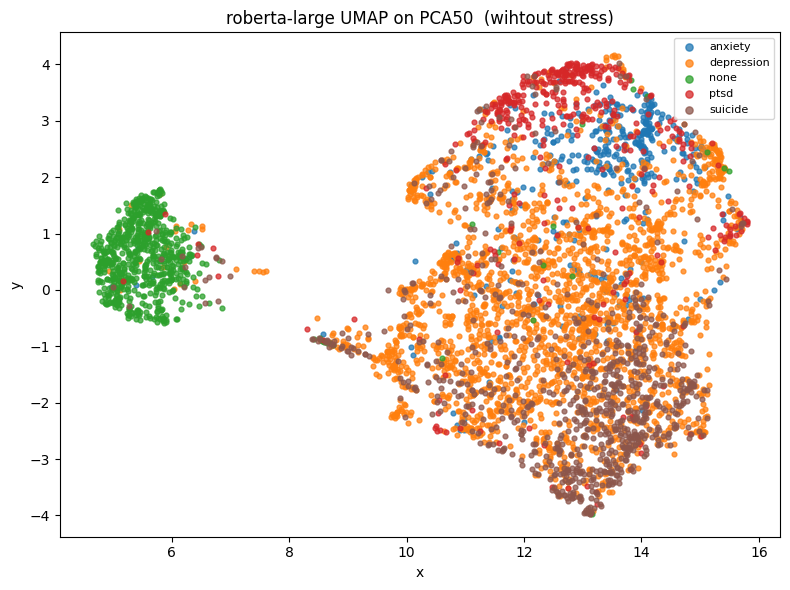

In [ ]:
# =========================================
# Step 4  Dimensionality reduction & visualization (no-stress dataset)
# Model: sentence-transformers/all-roberta-large-v1
# - Loads df_ns
# - Reuses embeddings if possible, else recomputes
# - PCA -> UMAP (tSNE fallback), single matplotlib plot
# - No files written
# =========================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

MODEL_KEY = "all_roberta_large_v1"
MODEL_NAME = "sentence-transformers/all-roberta-large-v1"
DATASET_NAME_NS = "combined_mental_condition_dataset_no_stress.csv"

# ---------- locate Data_Warehouse and load df_ns ----------
def find_data_warehouse(start: Path) -> Path:
    for p in [start] + list(start.parents):
        dw = p / "Data_Warehouse"
        if dw.exists():
            return dw
    raise FileNotFoundError("Could not locate a folder named Data_Warehouse")

try:
    script_dir = Path(__file__).resolve().parent
except NameError:
    script_dir = Path.cwd()

data_warehouse = find_data_warehouse(script_dir)

df_ns = pd.read_csv(data_warehouse / DATASET_NAME_NS)
required = {"text", "label"}
if not required.issubset(df_ns.columns):
    raise ValueError(f"Missing required columns: {required}")
df_ns["text"] = df_ns["text"].astype(str)
df_ns["label"] = df_ns["label"].astype(str)

texts_ns = df_ns["text"].tolist()
labels_ns = df_ns["label"].tolist()

# If you previously computed embeddings on the full dataset and kept that DataFrame:
# - try to set df_full from an existing variable 'df'
if "df_full" not in globals() and "df" in globals():
    df_full = df  # reuse your already-loaded full dataset, if present

# ---------- try to reuse full-dataset embeddings by masking out 'stress' ----------
def try_reuse_embeddings_ns():
    if "embeddings" not in globals() or MODEL_KEY not in embeddings:
        return None
    if "df_full" not in globals():
        return None

    X_full = embeddings[MODEL_KEY]
    if X_full.shape[0] != len(df_full):
        return None

    # mask full dataset to rows where label != 'stress'
    mask_no_stress = df_full["label"].astype(str).str.strip().str.lower().ne("stress")
    df_full_ns = df_full.loc[mask_no_stress]

    # reuse only if order and content match exactly
    if len(df_full_ns) == len(df_ns) and df_full_ns["text"].astype(str).tolist() == texts_ns:
        return X_full[mask_no_stress.values]
    return None

X_ns = try_reuse_embeddings_ns()

# ---------- recompute if reuse not possible ----------
if X_ns is None:
    try:
        from sentence_transformers import SentenceTransformer
    except ImportError as e:
        raise ImportError("Please install sentence-transformers: pip install -U sentence-transformers") from e
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    st_model = SentenceTransformer(MODEL_NAME, device=DEVICE)
    X_ns = st_model.encode(
        texts_ns,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True,
    ).astype(np.float32)
    print("Embeddings recomputed for no-stress dataset.")
else:
    print("Reused embeddings by subsetting the full dataset mask.")

# ---------- PCA -> UMAP (tSNE fallback) ----------
pca_50 = PCA(n_components=50, random_state=42)
X_ns_50 = pca_50.fit_transform(X_ns)

method_tag = "UMAP"
try:
    import umap
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    coords_2d = reducer.fit_transform(X_ns_50)
except Exception:
    from sklearn.manifold import TSNE
    method_tag = "tSNE"
    reducer = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=42)
    coords_2d = reducer.fit_transform(X_ns_50)

coords_df_ns = pd.DataFrame({"x": coords_2d[:, 0], "y": coords_2d[:, 1], "label": labels_ns})

# ---------- define consistent colors ----------
# pick a palette big enough for all labels
all_labels = sorted(df_full["label"].astype(str).unique())
palette = plt.cm.tab10.colors  # or plt.cm.Set3.colors, etc.
label_to_color = {lab: palette[i % len(palette)] for i, lab in enumerate(all_labels)}

# ---------- plot (for no-stress dataset) ----------
plt.figure(figsize=(8, 6))
label_display_map = {"suicide": "suicidal"}
for lab in sorted(coords_df_ns["label"].unique()):
    sub = coords_df_ns[coords_df_ns["label"] == lab]
    plt.scatter(
        sub["x"],
        sub["y"],
        s=12,
        alpha=0.75,
        label=lab,
        color=label_to_color[lab]  # <- consistent color
    )

plt.title(f"RoBERTa-large {method_tag} on PCA50  (wihtout stress)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
plt.show()


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


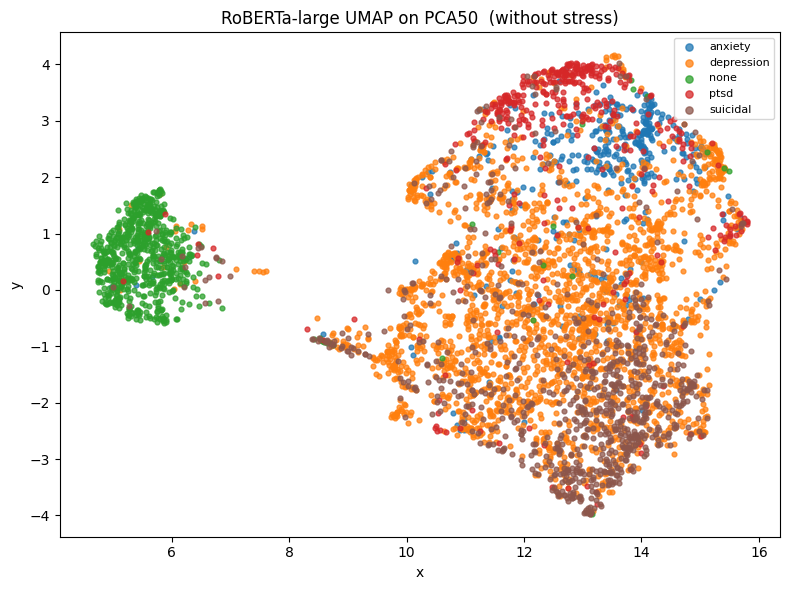

In [12]:
# ---------- PCA -> UMAP (tSNE fallback) ----------
n_comp = int(min(50, X_ns.shape[1], max(2, X_ns.shape[0] - 1)))
pca_50 = PCA(n_components=n_comp, random_state=42)
X_ns_50 = pca_50.fit_transform(X_ns)

method_tag = "UMAP"
try:
    import umap
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    coords_2d = reducer.fit_transform(X_ns_50)
except Exception:
    from sklearn.manifold import TSNE
    method_tag = "tSNE"
    # keep perplexity < n and reasonably large
    perplex = max(5, min(30, (len(X_ns_50) - 1) // 3))
    reducer = TSNE(n_components=2, init="pca", learning_rate="auto",
                   perplexity=perplex, random_state=42)
    coords_2d = reducer.fit_transform(X_ns_50)

coords_df_ns = pd.DataFrame({"x": coords_2d[:, 0], "y": coords_2d[:, 1], "label": labels_ns})

# ---------- colors ----------
# if df_full exists, use its label order to keep colors consistent across runs
if "df_full" in globals():
    all_labels = sorted(df_full["label"].astype(str).unique())
else:
    all_labels = sorted(coords_df_ns["label"].astype(str).unique())

palette = plt.cm.tab10.colors
label_to_color = {lab: palette[i % len(palette)] for i, lab in enumerate(all_labels)}

# ---------- plot for the no stress dataset ----------
plt.figure(figsize=(8, 6))

# display only rename
label_display_map = {"suicide": "suicidal"}

for lab in sorted(coords_df_ns["label"].unique()):
    sub = coords_df_ns[coords_df_ns["label"] == lab]
    display_lab = label_display_map.get(lab, lab)
    plt.scatter(
        sub["x"], sub["y"],
        s=12, alpha=0.75,
        label=display_lab,
        color=label_to_color.get(lab, palette[0])
    )

plt.title(f"RoBERTa-large {method_tag} on PCA{n_comp}  (without stress)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(markerscale=1.5, fontsize=8)
plt.tight_layout()
plt.show()


In [14]:
# Similarity for no stress dataset with all_roberta_large_v1
# Uses centroid cosine similarity between labels
# Does not write files

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

MODEL_KEY = "all_roberta_large_v1"
MODEL_NAME = "sentence-transformers/all-roberta-large-v1"

# require df_ns with columns ["text", "label"]
if "df_ns" not in globals():
    raise NameError("Please load the no stress dataset into df_ns with columns ['text', 'label'].")

texts_ns = df_ns["text"].astype(str).tolist()
labels_ns = df_ns["label"].astype(str)

def get_embeddings_ns() -> np.ndarray:
    # reuse precomputed embeddings if available
    if "X_ns" in globals() and isinstance(X_ns, np.ndarray) and X_ns.shape[0] == len(df_ns):
        return X_ns

    # try subsetting full dataset embeddings if available and aligned
    if "embeddings" in globals() and MODEL_KEY in embeddings and "df_full" in globals():
        X_full = embeddings[MODEL_KEY]
        if X_full.shape[0] == len(df_full):
            mask_no_stress = df_full["label"].astype(str).str.strip().str.lower().ne("stress")
            df_full_ns = df_full.loc[mask_no_stress]
            if len(df_full_ns) == len(df_ns) and df_full_ns["text"].astype(str).tolist() == texts_ns:
                return X_full[mask_no_stress.values]

    # otherwise compute embeddings for df_ns
    try:
        from sentence_transformers import SentenceTransformer
    except ImportError as e:
        raise ImportError("Please install sentence-transformers: pip install -U sentence-transformers") from e
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    st_model = SentenceTransformer(MODEL_NAME, device=DEVICE)
    X = st_model.encode(
        texts_ns,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True,
    ).astype(np.float32)
    return X

X = get_embeddings_ns()

# build centroid cosine similarity matrix
label_list = sorted(labels_ns.unique().tolist())
idx_map = {lab: np.where(labels_ns.values == lab)[0] for lab in label_list}
centroids = np.vstack([X[idxs].mean(axis=0) for lab, idxs in idx_map.items()])
sim = cosine_similarity(centroids)
sim_df_ns = pd.DataFrame(sim, index=label_list, columns=label_list)

def report_for_label(anchor: str, top_k: int | None = None) -> pd.DataFrame:
    s = sim_df_ns.loc[anchor].drop(anchor).sort_values(ascending=False)
    out = s.reset_index().rename(columns={"index": "other_label", anchor: "cosine_similarity"})
    return out.head(top_k) if top_k else out

# display similarity matrix and per label rankings
def safe_display(obj):
    try:
        display(obj)
    except NameError:
        print(obj)

print("Centroid cosine similarity among labels for no stress dataset (0 to 1 scale)")
safe_display(sim_df_ns.round(3))

for lab in label_list:
    print(f"\n{lab} vs others")
    safe_display(report_for_label(lab).round(3))


Centroid cosine similarity among labels for no stress dataset (0 to 1 scale)


,anxiety,depression,none,ptsd,suicide
anxiety,1.000,0.775,0.122,0.843,0.666
depression,0.775,1.000,0.163,0.730,0.929
none,0.122,0.163,1.000,0.058,0.114
ptsd,0.843,0.730,0.058,1.000,0.678
suicide,0.666,0.929,0.114,0.678,1.000



anxiety vs others


,other_label,cosine_similarity
0,ptsd,0.843
1,depression,0.775
2,suicide,0.666
3,none,0.122



depression vs others


,other_label,cosine_similarity
0,suicide,0.929
1,anxiety,0.775
2,ptsd,0.730
3,none,0.163



none vs others


,other_label,cosine_similarity
0,depression,0.163
1,anxiety,0.122
2,suicide,0.114
3,ptsd,0.058



ptsd vs others


,other_label,cosine_similarity
0,anxiety,0.843
1,depression,0.730
2,suicide,0.678
3,none,0.058



suicide vs others


,other_label,cosine_similarity
0,depression,0.929
1,ptsd,0.678
2,anxiety,0.666
3,none,0.114


In [15]:
# Clustering for the no stress dataset with all_roberta_large_v1
# Shows only label wise clustering results (counts and row wise percentages)
# Does not write files

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

MODEL_KEY = "all_roberta_large_v1"
MODEL_NAME = "sentence-transformers/all-roberta-large-v1"

# require df_ns with columns ["text", "label"]
if "df_ns" not in globals():
    # load if not already in memory
    from pathlib import Path
    def find_data_warehouse(start: Path) -> Path:
        for p in [start] + list(start.parents):
            dw = p / "Data_Warehouse"
            if dw.exists():
                return dw
        raise FileNotFoundError("Could not locate a folder named Data_Warehouse")
    try:
        script_dir = Path(__file__).resolve().parent
    except NameError:
        script_dir = Path.cwd()
    data_warehouse = find_data_warehouse(script_dir)
    df_ns = pd.read_csv(data_warehouse / "combined_mental_condition_dataset_no_stress.csv")

required_cols = {"text", "label"}
if not required_cols.issubset(df_ns.columns):
    raise ValueError(f"Missing required columns: {required_cols}")

df_ns = df_ns.copy()
df_ns["text"] = df_ns["text"].astype(str)
df_ns["label"] = df_ns["label"].astype(str)

labels_ns = df_ns["label"].astype(str)

# get embeddings X_ns for this dataset
def get_embeddings_ns() -> np.ndarray:
    # reuse precomputed subset if available
    if "X_ns" in globals() and isinstance(X_ns, np.ndarray) and X_ns.shape[0] == len(df_ns):
        return X_ns
    # try subsetting full dataset embeddings if available and aligned
    if "embeddings" in globals() and MODEL_KEY in embeddings and "df_full" in globals():
        X_full = embeddings[MODEL_KEY]
        if X_full.shape[0] == len(df_full):
            mask_no_stress = df_full["label"].astype(str).str.strip().str.lower().ne("stress")
            df_full_ns = df_full.loc[mask_no_stress]
            if len(df_full_ns) == len(df_ns) and df_full_ns["text"].astype(str).tolist() == df_ns["text"].tolist():
                return X_full[mask_no_stress.values]
    # otherwise compute embeddings now
    try:
        from sentence_transformers import SentenceTransformer
    except ImportError as e:
        raise ImportError("Please install sentence transformers: pip install -U sentence-transformers") from e
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    st_model = SentenceTransformer(MODEL_NAME, device=DEVICE)
    X = st_model.encode(
        df_ns["text"].tolist(),
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=True,
    ).astype(np.float32)
    return X

X_ns = get_embeddings_ns()
if X_ns.shape[0] != len(df_ns):
    raise ValueError("Row count mismatch between embeddings and df_ns")

# k means with k equal to number of labels
label_set = sorted(labels_ns.unique().tolist())
k = len(label_set)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
cluster_ids = kmeans.fit_predict(X_ns)

# label wise clustering results
ct = pd.crosstab(pd.Series(labels_ns, name="true_label"),
                 pd.Series(cluster_ids, name="cluster"))

# row wise percentages for easier reading
ct_pct = ct.div(ct.sum(axis=1), axis=0).round(3)

# show only label wise results
def safe_display(obj):
    try:
        display(obj)
    except NameError:
        print(obj)

print("Label wise cluster counts")
safe_display(ct)

print("\nLabel wise cluster percentages")
safe_display(ct_pct)


c:\Users\nipua\AppData\Local\anaconda3\envs\py312_xai\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=19.
  warnings.warn(


Label wise cluster counts


cluster,0,1,2,3,4
true_label,,,,,
anxiety,44,6,65,290,11
depression,676,404,909,296,37
none,3,0,2,9,693
ptsd,53,17,25,311,8
suicide,196,457,109,40,36



Label wise cluster percentages


cluster,0,1,2,3,4
true_label,,,,,
anxiety,0.106,0.014,0.156,0.697,0.026
depression,0.291,0.174,0.391,0.127,0.016
none,0.004,0.000,0.003,0.013,0.980
ptsd,0.128,0.041,0.060,0.751,0.019
suicide,0.234,0.545,0.130,0.048,0.043
